<a href="https://colab.research.google.com/github/goerlitz/image-classification/blob/master/catsdogs/Cats_%26_Dogs_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats vs. Dogs: Transfer Learning with little data

This kernel is inspired by the Keras blog post [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) (by Francois Chollet, Sun 05 June 2016). **This blog post is a must read for everyone interested in transfer learning with ConvNets.**

Following, we will learn how to

1. reproduce the results of the blog post - using limited training data (2000 images) and a pretrained VGG16 model.
2. compare the performance of VGG16 with other pretrained Convolutional Nets (InceptionV3 and ResNet50).

# PART I

**Reproduce results from [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)**

1. Training a small convnet from scratch (~80% accuracy)
2. Using the bottleneck features of a pre-trained VGG-16 network (~90% accuracy)
3. Fine-tuning the top layers of a a pre-trained VGG-16 network (~93% accuracy)

## Pre-requisites

### Dataset Preparation

The setup in the [Keras blog post](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) uses only 2000 training examples (1000 per class) and 400 validation examples (200 per class) which are located in separate folders. Therefore, we create the same folder structure and copy 1000+400 cat and dog images each from the full dataset of 25,000 images.

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

print('TensorFlow', tf.__version__)

TensorFlow 1.14.0


Using TensorFlow backend.


## Download Data

In [2]:
%%time
!if [[ ! -d data ]]; then mkdir data; fi && \
    if [[ ! -f dogscats.zip ]]; then wget http://files.fast.ai/data/dogscats.zip; fi && \
    unzip -qq -o dogscats.zip -d data/

CPU times: user 112 ms, sys: 17.4 ms, total: 129 ms
Wall time: 14 s


# Inspect Data

In [3]:
!du data/ -h

295M	data/dogscats/train/dogs
253M	data/dogscats/train/cats
548M	data/dogscats/train
26M	data/dogscats/valid/dogs
22M	data/dogscats/valid/cats
48M	data/dogscats/valid
204K	data/dogscats/sample/train/dogs
156K	data/dogscats/sample/train/cats
364K	data/dogscats/sample/train
104K	data/dogscats/sample/valid/dogs
72K	data/dogscats/sample/valid/cats
216K	data/dogscats/sample/valid
584K	data/dogscats/sample
4.0K	data/dogscats/models
298M	data/dogscats/test1
893M	data/dogscats
893M	data/


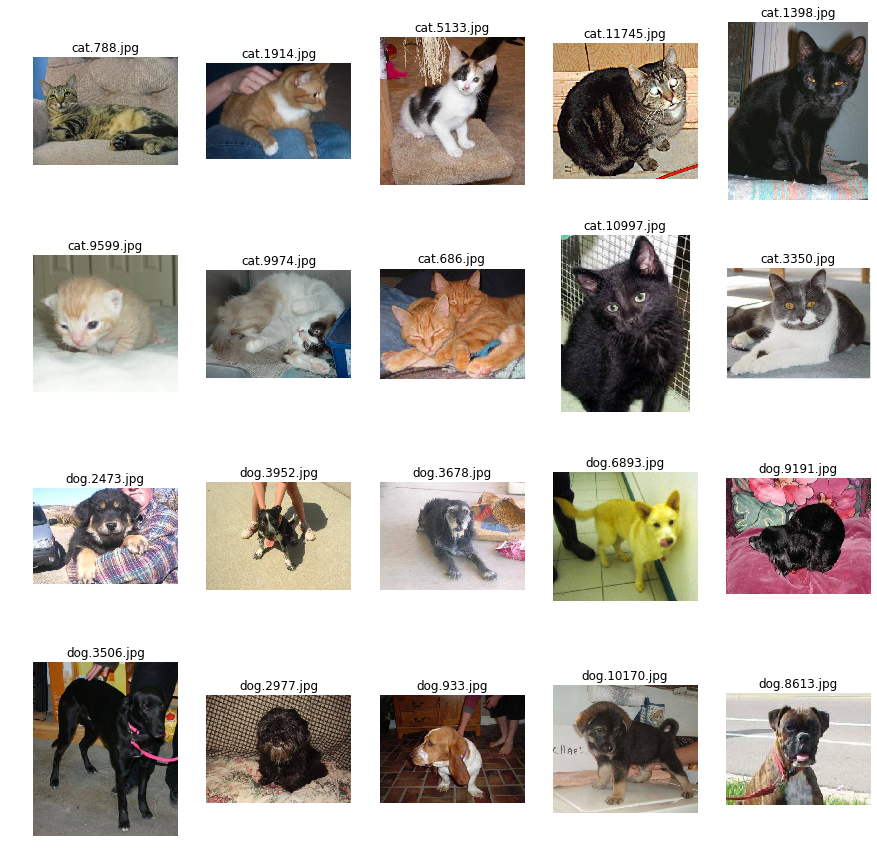

In [4]:
data_folder = Path('data/dogscats/')

train_folders = [data_folder/'train'/x for x in ['cats', 'dogs']]
pathlist = [[path/f for f in os.listdir(path)[:10]] for path in train_folders]

fig, axs = plt.subplots(4, 5, figsize=(15,15))

for ax, path in zip(axs.flatten(), [p for paths in pathlist for p in paths]):
    ax.imshow(plt.imread(path))
    ax.set_title(path.name)
    ax.axis('off')

### Data Augmentation

Data augmentation is a common approach to prevent overfitting by creating variations of the original training images. The  `DataImageGenerator` is used to apply different transformations on the images (e.g. rotating, zooming, flipping, shifting the images).

In [ ]:
# define image transformations
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img_samples = 16
image_dir = '../preview/'
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

img = load_img(data_folder/'train/cats/cat.8.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

from itertools import islice
list(islice(datagen.flow(x, batch_size=1, save_to_dir=image_dir, save_prefix='cat', save_format='jpeg'), img_samples));

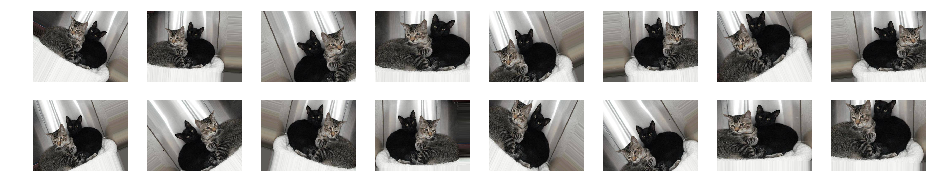

In [6]:
rows, cols = 2, img_samples // 2
fig, axs = plt.subplots(rows, cols, figsize=(16,3))

for ax, img in zip(axs.flatten(), os.listdir(image_dir)[:img_samples]):
    ax.imshow(load_img(image_dir+img))
    ax.axis('off')

## Training a Small ConvNet from Scratch

A classic setup of three convolution layers with a ReLU activation, followed by max-pooling layers. On top two fully-connected layers and a signle node with sigmoid activation for binary classification (cat or dog).

In [ ]:
import numpy as np
import pandas as pd
import keras, tensorflow
import time

print('Keras', keras.__version__)
print('TensorFlow', tensorflow.__version__)

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

input_tensor = Input(shape=(150,150,3))  # input_shape for Theano should be (3, 150,150)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### Provide Training and Validation Image Using ImageDataGenerator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_dir      = '../data/train'
validation_dir = '../data/validation'

train_samples      = 2000
validation_samples = 800

target_size    = (150,150)  # all images will be resized to 150x150
batch_size     = 16

# rescale and augment training data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# rescale validation data
validation_datagen = ImageDataGenerator(
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

Ready for training. ~16s per epoch on GPU, ~60s per epoch on CPU.

In [ ]:
epochs = 30

start_time = time.time()
history_simple = model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

### Investigating Model Accuracy

The results can vary due to the random initialization. But the (validation) accuracy should be more or less close to 80% (like in the original blog post). Looking at the graphs we ses that the training accuracy continuously improves while the validation accuracy does not change much after ~15 epochs - a clear sign for overfitting.

In [ ]:
def plot_history(history, acc_line=None, title=None, acc_lim=[0.5,1.0]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    if title:
        fig.suptitle(title, fontsize=16)
    
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    if acc_line:
        ax1.axhline(y=acc_line, linewidth=2, linestyle='dashed', color='lightgrey')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    #ax1.set_yticks(np.arange(0., 1.1, .1))
    ax1.set_ylim(acc_lim)
    ax1.legend(['Train', 'Test'])
    ax1.grid(b=True, which='major', color='lightgrey', linestyle='dotted')
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim([0, 1.2])
    ax2.legend(['Train', 'Test'])
    ax2.grid(b=True, which='major', color='lightgrey', linestyle='dotted')

In [ ]:
plot_history(history_simple, acc_line=0.8, title='Simple ConvNet')

## Using bottleneck features of a pre-trained VGG16 network

As in the blog post we will be using VGG16 with pre-trained weights based on ImageNet divided into two steps:

  * compute bottleneck features for all 2000 training images and 800 validation images of cats and dogs
  * create new binary classifier and train it with bottleneck features.

**Note: there is no data augmentation applied - so expect to see more overfitting.**

### Create VGG16 model with pre-trained weights

**Important**: Exclude the top layers (the dense classfication layers) because we are only interested in the output of the convolutional layers.

In [ ]:
from keras.applications.vgg16 import VGG16

weights_vgg16 = '../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

base_model_vgg16 = VGG16(weights=weights_vgg16, include_top=False, input_shape=(150,150,3))

### Extract Bottleneck Features

See also the [code referenced in Keras blog post](https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069).

In [ ]:
def get_bottleneck_features(model, image_dir, target_size, samples, batch_size=16):
    datagen   = ImageDataGenerator(rescale=1. / 255)
    generator = datagen.flow_from_directory(image_dir,
                                            target_size=target_size,
                                            batch_size=batch_size,
                                            class_mode=None,
                                            shuffle=False)
    return model.predict_generator(generator, samples // batch_size)

train_data_vgg16 = get_bottleneck_features(base_model_vgg16, train_dir, target_size, train_samples, batch_size)
print('created bottleneck features for training:', train_data_vgg16.shape)

validation_data_vgg16 = get_bottleneck_features(base_model_vgg16, validation_dir, target_size, validation_samples, batch_size)
print('created bottleneck features for validation:', validation_data_vgg16.shape)

train_labels = np.array([0] * (train_samples // 2) + [1] * (train_samples // 2))
validation_labels = np.array([0] * (validation_samples // 2) + [1] * (validation_samples // 2))

### Train a Classifier with Bottleneck Features

Classifier Setup: A dense layer with 256 neurons plus Dropout of 0.5 with a final layer of one neuron.

In [ ]:
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout

def get_top_model(input_shape):
    input = Input(input_shape)
    x = Flatten()(input)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    prediction = Dense(1, activation='sigmoid')(x)
    return Model(inputs=input, outputs=prediction)

top_model_vgg16 = get_top_model(train_data_vgg16.shape[1:])

top_model_vgg16.compile(loss='binary_crossentropy',
                        optimizer='rmsprop',
                        metrics=['accuracy'])

In [ ]:
epochs = 30

start_time = time.time()
history_vgg16_top = top_model_vgg16.fit(train_data_vgg16, train_labels,
                                        verbose=2,
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        validation_data=(validation_data_vgg16, validation_labels))
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

In [ ]:
model_weigths_file = 'bottleneck_fc_model_vgg16.h5'
top_model_vgg16.save_weights(model_weigths_file)

In [ ]:
plot_history(history_vgg16_top, acc_line=0.9, title='Pre-trained VGG16 with no augmentation', acc_lim=[0.75,1.0])

## Fine-tuning the top layers of a pre-trained network

**CAUTION:** The [original code](https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975) in the blog article using `base_model.add()` to join the pre-trained VGG16 model with the pre-trained classifier does not work (anymore). Instead, a new `Sequential` model has to be created. (see also https://github.com/keras-team/keras/issues/7338#issuecomment-315973050).

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense, Dropout

In [ ]:
# load pre-trained VGG16 network (without classfication layers)
base_model_vgg16 = VGG16(weights=weights_vgg16, include_top=False, input_shape=(150,150,3))
print('Model loaded.')

# set all but the last the last conv block to non-trainable (weights will not be updated)
for layer in base_model_vgg16.layers[:15]:
    layer.trainable = False

# create a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model_vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
top_model.load_weights(model_weigths_file)

# add the model on top of the convolutional base
model = Model(inputs = base_model_vgg16.input, outputs = top_model(base_model_vgg16.output))

In [ ]:
from keras import optimizers

# compile model with a very slow learning rate
model.compile(loss='binary_crossentropy',
              #optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              #optimizer=optimizers.RMSprop(lr=1e-5),
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['accuracy'])

In [ ]:
epochs = 30

start_time = time.time()
history_tuned = model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

In [ ]:
plot_history(history_tuned, acc_line=0.93, title='Pre-trained VGG16 + pre-trained top model', acc_lim=[0.75,1.0])

# PART II

**Compare different pretrained convolutional networks.**

1. VGG-16 (~90% accuracy)
2. Inception v3  (~95% accuracy)
3. ResNet-50  (~98% accuracy)

### Create VGG16 model with pre-trained weights

In [ ]:
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout

# build the VGG16 network
base_model = VGG16(weights=weights_vgg16, include_top=False, input_shape=(150,150,3))

# freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_vgg16base = Model(inputs=base_model.input, outputs=predictions)

print(model_vgg16base.summary())

In [ ]:
model_vgg16base.compile(loss='binary_crossentropy',
                        optimizer='rmsprop',
                        metrics=['accuracy'])

In [ ]:
epochs = 30

start_time = time.time()
history_vgg16base = model_vgg16base.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

In [ ]:
plot_history(history_vgg16base, acc_line=0.9, title='Pre-trained VGG16', acc_lim=[0.75, 1.0])

### Use Pre-trained InceptionV3 Model

In [ ]:
from keras.applications.inception_v3 import InceptionV3

weights_incv3 = '../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# load pre-trained weights and add global average pooling layer
base_model_incv3 = InceptionV3(weights=weights_incv3, input_shape=(150,150,3), include_top=False, pooling='avg')

# freeze convolutional layers
for layer in base_model_incv3.layers:
    layer.trainable = False

# define classification layers
#x = Dense(1024, activation='relu')(base_model_incv3.output)
#predictions = Dense(1, activation='sigmoid')(x)
x = Dense(256, activation='relu')(base_model_incv3.output)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_incv3 = Model(inputs=base_model_incv3.input, outputs=predictions)
#print(model_incv3.summary())

### Prepare Model Training Setup

In [ ]:
model_incv3.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(lr=0.0001),
                    metrics=['accuracy'])

### Provide Training and Validation Images using ImageDataGenerator

**Caution**: InceptionV3 requires a different image preprocessing than VGG.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

def prep(image):
    # copy image to prevent overwriting
    return preprocess_input(image.copy())

train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function=prep)

test_datagen = ImageDataGenerator(preprocessing_function=prep)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

In [ ]:
epochs = 30

start_time = time.time()
history_incv3 = model_incv3.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

In [ ]:
plot_history(history_incv3, acc_line=0.95, title="Pre-trained InceptionV3", acc_lim=[0.75,1.0])

## ResNet50

In [ ]:
from keras.applications.resnet50 import ResNet50, preprocess_input

weights_resnet50 = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

base_model = ResNet50(weights = weights_resnet50, include_top = False, pooling = 'avg')

In [ ]:
model = Sequential()
model.add(base_model)

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].trainable = False
print(model.summary())

In [ ]:
model.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(lr=0.0001),
                    metrics=['accuracy'])

In [ ]:
def prep(image):
    # copy image to prevent overwriting
    return preprocess_input(image.copy())

train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function=prep)

test_datagen = ImageDataGenerator(preprocessing_function=prep)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

In [ ]:
epochs = 30

start_time = time.time()
history_resnet50 = model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

In [ ]:
plot_history(history_resnet50, acc_line=0.97, title="Pre-trained ResNet-50", acc_lim=[0.85,1.0])